In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib_inline
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.font_manager as fm
import collections
from collections import Counter

In [2]:
from konlpy.tag import Mecab

In [3]:
plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

['NanumGothic']


In [6]:
df1 = pd.read_csv('D:/Code/Presidential_Election_Analysis/Crawling/윤석열/윤석열_2022-02-09~2022-02-16_result2.csv',encoding='utf-8')
df2 = pd.read_csv('D:/Code/Presidential_Election_Analysis/Crawling/윤석열/윤석열_2022-02-16~2022-02-23_result2.csv',encoding='utf-8')
df3 = pd.read_csv('D:/Code/Presidential_Election_Analysis/Crawling/윤석열/윤석열_2022-02-23~2022-03-02_result2.csv',encoding='utf-8')
df4 = pd.read_csv('D:/Code/Presidential_Election_Analysis/Crawling/윤석열/윤석열_2022-03-02~2022-03-09_result2.csv',encoding='utf-8')

In [7]:
df = pd.read_csv('D:/Code/Presidential_Election_Analysis/Crawling/윤석열/윤석열_2022-02-09~2022-03-09_result2.csv',encoding='utf-8')

In [6]:
dfs = [df1, df2, df3, df4]

In [7]:
n=1
for i in dfs:
    print('{}주차 윤석열 데이터 개수: {}'.format(n, len(i['text'])))
    n = n+1

1주차 윤석열 데이터 개수: 7000
2주차 윤석열 데이터 개수: 7000
3주차 윤석열 데이터 개수: 7000
4주차 윤석열 데이터 개수: 7000


In [8]:
#긍정 1, 부정 0
print('2022-02-09~2022-02-16 긍정 리뷰 갯수: {}'.format(df1['label'].value_counts()[1]))
print('2022-02-09~2022-02-16 부정 리뷰 갯수: {}'.format(df1['label'].value_counts()[0]))
print('2022-02-16~2022-02-23 긍정 리뷰 갯수: {}'.format(df2['label'].value_counts()[1]))
print('2022-02-16~2022-02-23 부정 리뷰 갯수: {}'.format(df2['label'].value_counts()[0]))
print('2022-02-23~2022-03-02 긍정 리뷰 갯수: {}'.format(df3['label'].value_counts()[1]))
print('2022-02-23~2022-03-02 부정 리뷰 갯수: {}'.format(df3['label'].value_counts()[0]))
print('2022-03-02~2022-03-09 긍정 리뷰 갯수: {}'.format(df4['label'].value_counts()[1]))
print('2022-03-02~2022-03-09 부정 리뷰 갯수: {}'.format(df4['label'].value_counts()[0]))

2022-02-09~2022-02-16 긍정 리뷰 갯수: 1687
2022-02-09~2022-02-16 부정 리뷰 갯수: 5313
2022-02-16~2022-02-23 긍정 리뷰 갯수: 1853
2022-02-16~2022-02-23 부정 리뷰 갯수: 5147
2022-02-23~2022-03-02 긍정 리뷰 갯수: 1759
2022-02-23~2022-03-02 부정 리뷰 갯수: 5241
2022-03-02~2022-03-09 긍정 리뷰 갯수: 1784
2022-03-02~2022-03-09 부정 리뷰 갯수: 5216


### 긍정, 부정 분포 확인

In [10]:
# 주차별 긍정 부정 갯수 확인용
pos = []
for i in dfs:
    if i['label'].value_counts()[1]:
        pos.append(i['label'].value_counts()[1])
neg = []
for i in dfs:
    if i['label'].value_counts()[0]:
        neg.append(i['label'].value_counts()[0])

<AxesSubplot:title={'center':'윤석열 주차별 레이블 분포'}>

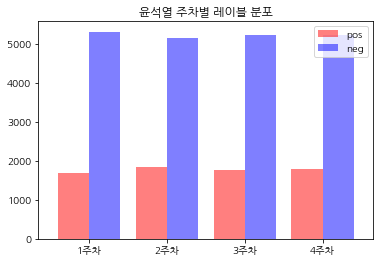

In [11]:
label = ['1주차', '2주차', '3주차', '4주차']
week = pd.DataFrame({'pos':pos, 'neg':neg}, index=label)
week.plot.bar(color=['r', 'b'], width=0.8, title='윤석열 주차별 레이블 분포', alpha=0.5, rot=0)

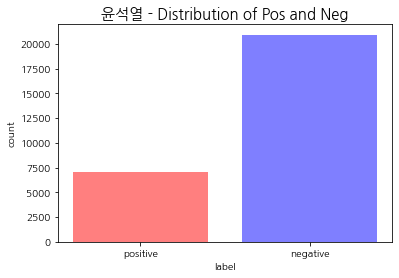

In [12]:
# 전체 데이터 분포 확인
def posNneg(df):
    label = ['positive', 'negative']
    index =  np.arange(len(df['label']))
    value = [df['label'].value_counts()[1], df['label'].value_counts()[0]]
    plt.bar(label, value, color=['r', 'b'], alpha=0.5)
    plt.title('윤석열 - Distribution of Pos and Neg', fontsize=15)
    plt.xlabel('label')
    plt.ylabel('count')
    plt.show()
posNneg(df)

### 전처리 코드

In [14]:
# Preprocessing code with Mecab
#dicpath="/usr/local/lib/mecab/dic/mecab-ko-dic"
mecab = Mecab(r"C:/mecab/mecab-ko-dic") # Mecab User Dic Path

def preprocessing_mecab(readData):
    
    #### Clean text
    #sentence = CleanText(readData)
    
    #### Tokenize
    morphs = mecab.pos(readData)
    
    JOSA = ["JKS", "JKC", "JKG", "JKO", "JKB", "JKV", "JKQ", "JX", "JC"] # 조사
    SIGN = ["SF", "SE", "SSO", "SSC", "SC", "SY"] # 문장 부호
    TERMINATION = ["EP", "EF", "EC", "ETN", "ETM"] # 어미
    SUPPORT_VERB = ["VX"] # 보조 용언
    NUMBER = ["SN"]
    
    # Remove JOSA, EOMI, etc
    morphs[:] = (morph for morph in morphs if morph[1] not in JOSA+SIGN+TERMINATION+SUPPORT_VERB)
        
    # Remove length-1 words  
    morphs[:] = (morph for morph in morphs if not (len(morph[0]) == 1))
    
    # Remove Numbers
    morphs[:] = (morph for morph in morphs if morph[1] not in NUMBER)
   
    # Result pop-up
    result = []
    for morph in morphs:
        result.append(morph[0])
        
    return result

### 전체 텍스트 단어 빈도수 및 워드클라우드 생성

In [15]:
text = [' '.join(preprocessing_mecab(t)) for t in df['text']]
m_tokenized = df['text'].apply(lambda x: preprocessing_mecab(x))

In [17]:
# 불용어 리스트 생성
stop_words = pd.read_csv('./한국어불용어100.txt', sep = "\t", engine='python')
stop_words = list(stop_words["word"])

In [18]:
# 리스트 외에 의미없다고 판단되는 단어 리스트, 윤석열은 키워드이기 때문에 제외
stopwords = ['윤석열', '한다', '세요', '합니다', '입니다', 'ㅋㅋㅋ', 'ㅋㅋ','진짜', '아니', '근데', '그냥', '라고', '한다고', '해서', '이런', '어차피', '버리', '된다는','생겼', '인데', '해도', '된다', '이거', ]
stopwords = stopwords+stop_words

In [19]:
# 단어 빈도수 그래프 만들기
def word_frequency(m_tokenized):
    n_corpus = [] 
    for t in m_tokenized:
        for j in t:
            if j not in stopwords:
                n_corpus.append(j) #mecab에서 명사 추출

    count = collections.Counter(n_corpus) 
    most = count.most_common() #빈도 수 순으로 추출 
    x, y= [], [] 
    for word,count in most[:40]: 
        x.append(word) 
        y.append(count)
    #plt.rc('font',family='NanumGothic.ttf')
    plt.rcParams['font.family'] = "NanumGothic"
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(10,10)) 
    sns.barplot(x=y,y=x)

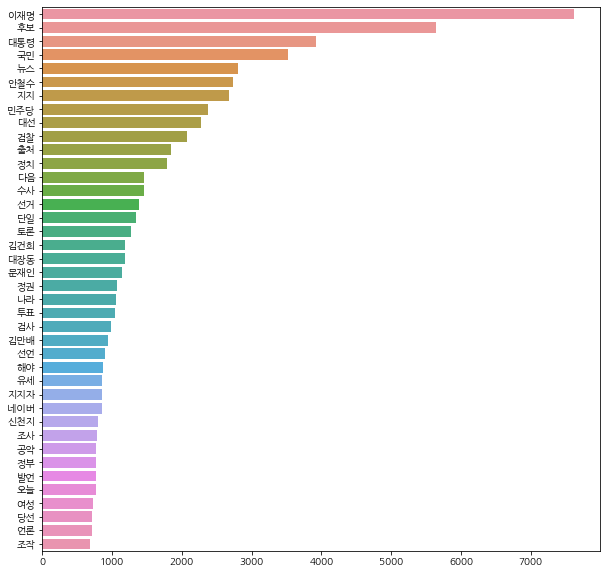

In [20]:
# 전체 텍스트 단어 빈도수
word_frequency(m_tokenized)

In [21]:
def make_wordcloud(text):
    font_path = 'C:/Users/Erin/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
    wordcloud = WordCloud(font_path=font_path,
                background_color="black",
                stopwords=stopwords, 
                max_words=100, 
                #max_font_size=50, 
                width=500,
                height=500,
                random_state=1,
                scale=2).generate(''.join(text))
    fig = plt.figure(1, figsize=(8,8)) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('on')
    plt.show()

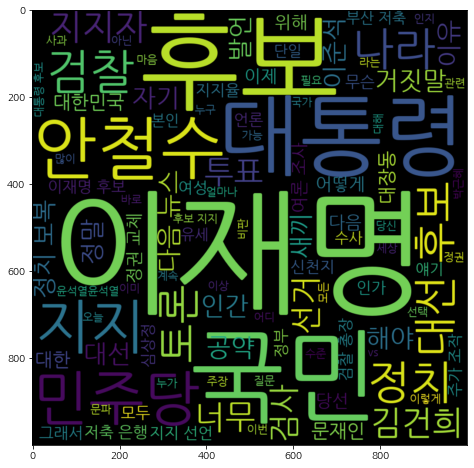

In [22]:
# 전체 텍스트
make_wordcloud(text)

### 주차별 단어 빈도수 & 워드 클라우드 생성

In [24]:
# 단어 빈도수용 전처리된 string 요소 리스트 만들기
df1_text = [' '.join(preprocessing_mecab(t)) for t in df1['text']]
df2_text = [' '.join(preprocessing_mecab(t)) for t in df2['text']]
df3_text = [' '.join(preprocessing_mecab(t)) for t in df3['text']]
df4_text = [' '.join(preprocessing_mecab(t)) for t in df4['text']]

In [25]:
# 워드 클라우드용 전처리 및 토큰화된 리스트 만들기
df1_tokenized1 = df1['text'].apply(lambda x: preprocessing_mecab(x))
df2_tokenized2 = df2['text'].apply(lambda x: preprocessing_mecab(x))
df3_tokenized3 = df3['text'].apply(lambda x: preprocessing_mecab(x))
df3_tokenized4 = df4['text'].apply(lambda x: preprocessing_mecab(x))

In [26]:
dfs_text = [df1_text,df2_text,df3_text, df4_text]
dfs_tokenized = [df1_tokenized1, df2_tokenized2, df3_tokenized3, df3_tokenized4]

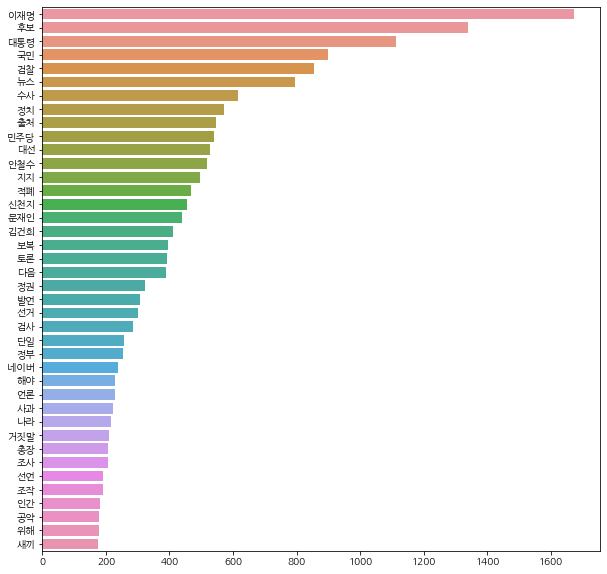

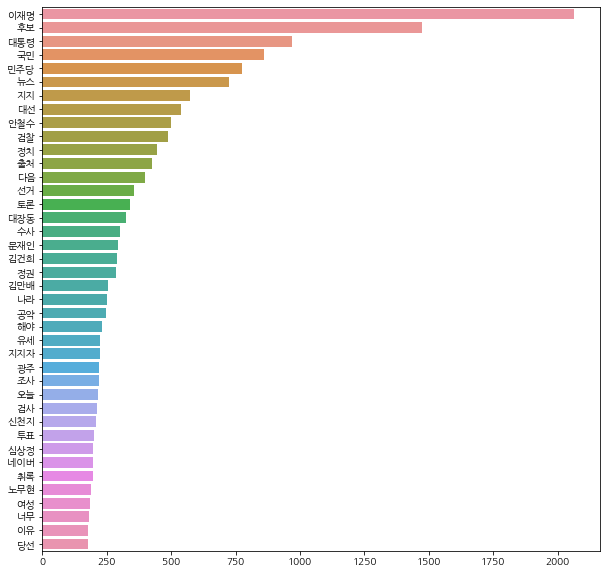

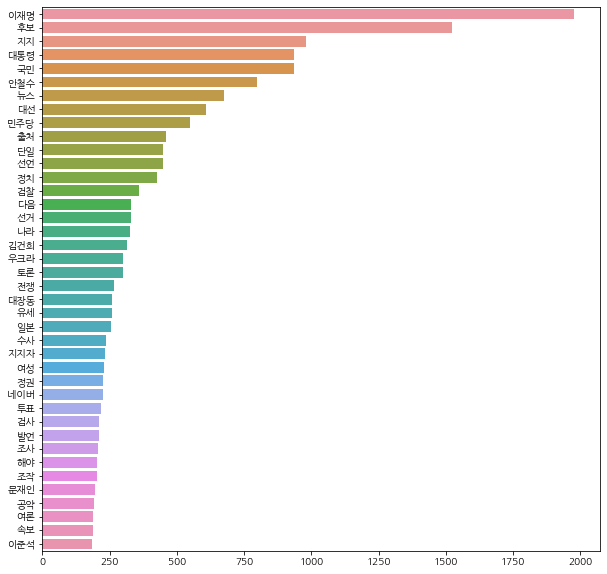

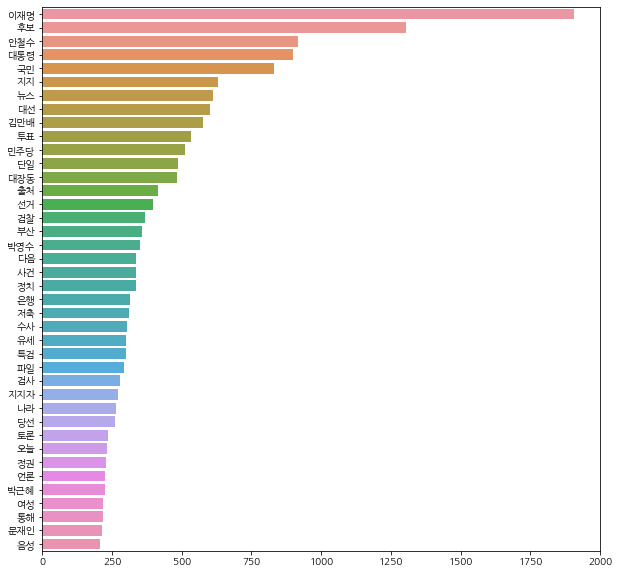

In [28]:
# 주차별 단어 빈도수 생성
for i in dfs_tokenized:
    word_frequency(i)

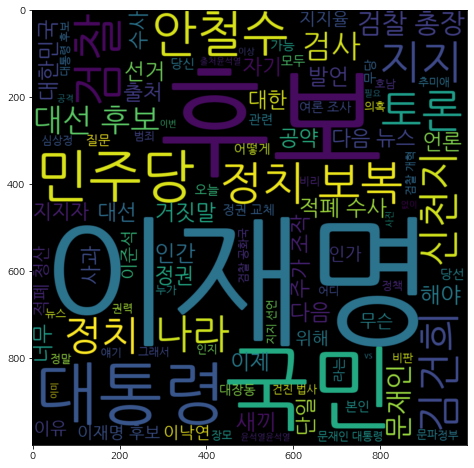

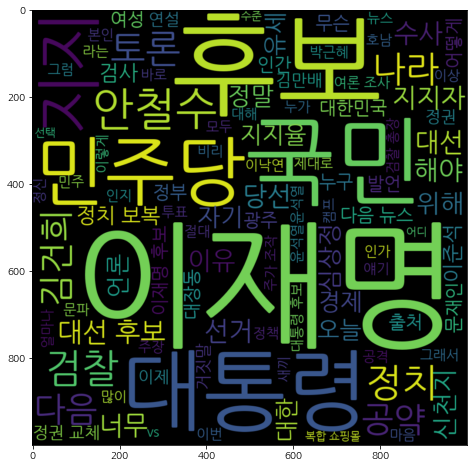

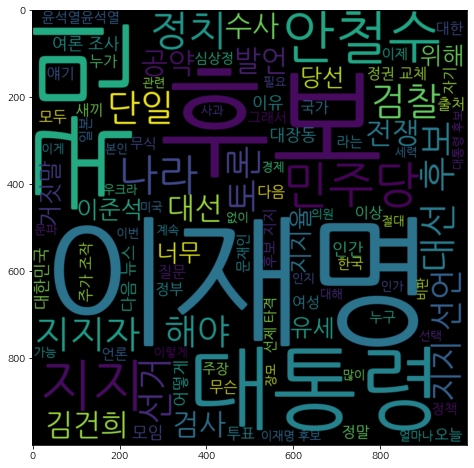

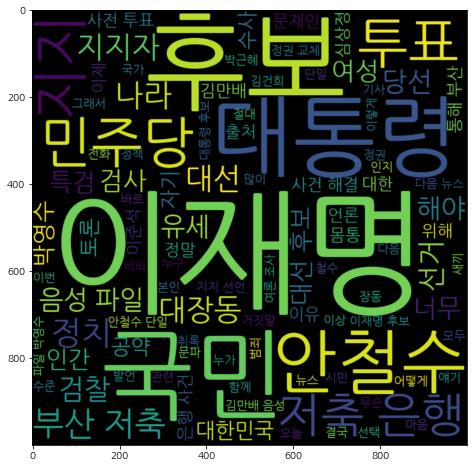

In [29]:
# 주차별 워드 클라우드 생성
for i in dfs_text:
    make_wordcloud(i)

### 날짜별 최다 빈도 단어 추출

In [32]:
stopwords2 = ['뉴스', '출처', '국민','대통령','후보','이재명', '윤석열', '한다', '세요', '합니다', '입니다', 'ㅋㅋㅋ', 'ㅋㅋ','진짜', '아니', '근데', '그냥', '라고', '한다고', '해서', '이런', '어차피', '버리', '된다는','생겼', '인데', '해도', '된다', '이거', ]
stopwords = stopwords+stopwords2

In [33]:
df['tokenized'] = df['text'].apply(lambda x: preprocessing_mecab(x))
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

c:\Users\Erin\anaconda3\envs\torch1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


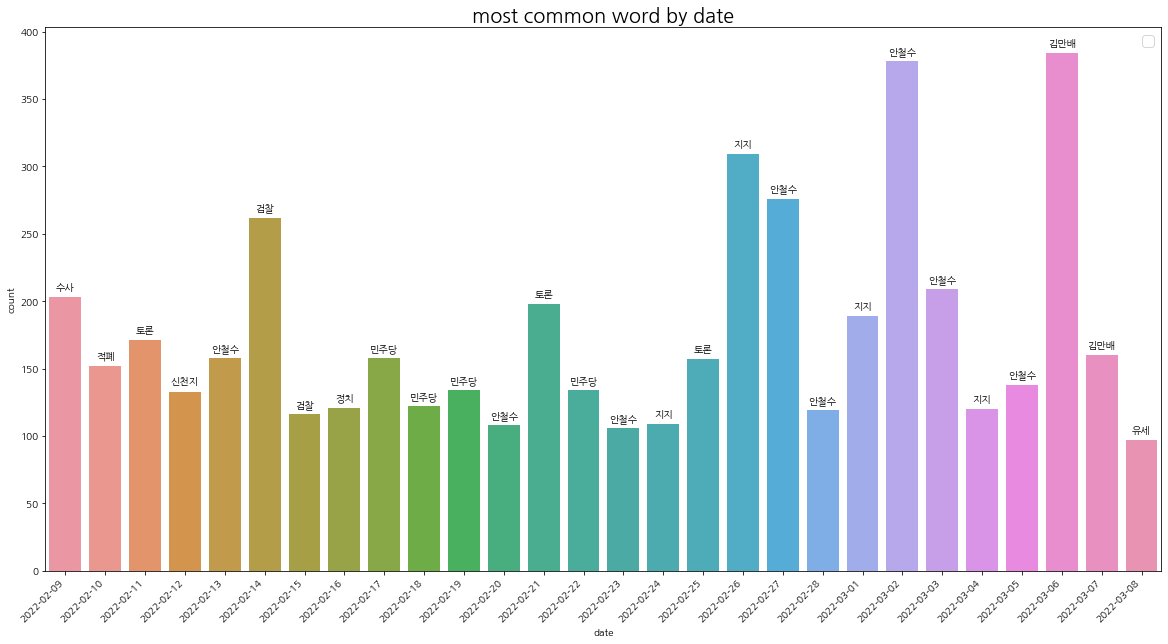

In [34]:
def common_words(words, k):
    c = Counter(words)
    cw = c.most_common(k)
    return c, cw

def add_value_labels(ax, df, spacing=5):
    for idx, rect in enumerate(ax.patches):
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{0}".format(df['word'][idx])

        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)

# 날짜별 가장 많이 언급된 단어와 단어의 갯수를 dict형태로 가져와서 dataframe으로 만들어주는 과정
date = []
word_list = []
count_list = []

for i in df['Datetime'].unique():
    tokenizing = sum(df[df['Datetime'] == i]['tokenized'],[])
    c, cw = common_words(tokenizing, 1)    
    word = cw[0][0]
    count = cw[0][1]
    date.append(i)
    word_list.append(word)
    count_list.append(count)
    
dateworddict = {'date' : date, 'word' : word_list, 'count' : count_list}
daily_df = pd.DataFrame(dateworddict, columns=['date', 'word', 'count'])

# graph
fig, ax = plt.subplots(1, figsize=(20,10))
plot = sns.barplot(daily_df['date'], daily_df['count'])
add_value_labels(ax, daily_df)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('most common word by date', fontsize=20)
plt.legend(fontsize=15)
#plt.save_fig("most common word by date")

### 해시태그 추출하기

In [35]:
# 정규표현식으로 #과 함께 있는 단어 추출 및 리스트 생성
import re
p = re.compile('[#]+[0-9a-zA-Z_ㄱ-ㅎ가-힣]+')
hash = []
for i in df['text']:
    hash.extend(p.findall(i))

In [36]:
# 해시태그 빈도수 확인
from collections import Counter
Counter(hash).most_common()

[('#윤석열', 1043),
 ('#이재명', 242),
 ('#국민의힘', 117),
 ('#shorts', 100),
 ('#안철수', 87),
 ('#대선', 83),
 ('#김건희', 71),
 ('#대장동', 59),
 ('#2번엔', 43),
 ('#팩트TV', 37),
 ('#뉴데일리', 36),
 ('#민주당', 34),
 ('#심상정', 32),
 ('#김만배', 29),
 ('#나를위해이재명', 28),
 ('#대선토론', 28),
 ('#Shorts', 27),
 ('#공멸', 26),
 ('#문재인', 25),
 ('#TV토론', 24),
 ('#팩트TV플러스', 24),
 ('#여성이', 23),
 ('#검찰개혁', 22),
 ('#뉴스', 22),
 ('#윤석열찍고', 22),
 ('#SBS뉴스', 21),
 ('#이재명은합니다', 19),
 ('#신천지', 19),
 ('#기호2번', 18),
 ('#단일화', 17),
 ('#정권교체', 16),
 ('#한동훈', 16),
 ('#최은순', 16),
 ('#부산저축은행', 16),
 ('#최신뉴스', 16),
 ('#박영수', 16),
 ('#사전투표', 16),
 ('#앞으로', 15),
 ('#윤석열은', 15),
 ('#이준석', 15),
 ('#더불어민주당', 15),
 ('#제대로', 14),
 ('#거짓말', 14),
 ('#대선특별생방송', 14),
 ('#주가조작', 13),
 ('#TikTok', 13),
 ('#대선후보', 12),
 ('#도이치모터스', 12),
 ('#언론개혁', 12),
 ('#나를위해', 12),
 ('#착한투표', 12),
 ('#검찰', 11),
 ('#여론조사', 11),
 ('#정치보복', 11),
 ('#윤석열처벌', 10),
 ('#본부장비리', 10),
 ('#검찰공화국', 10),
 ('#토론', 10),
 ('#박근혜', 10),
 ('#2', 10),
 ('#뉴스타파', 10),
 ('#윤석열OUT', 10),
 ('#선라

In [37]:
def hashtag(wordInfo):
        Sorted_Dict_Values = sorted(wordInfo.values(), reverse=False)
        Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=False)
        plt.figure(figsize=(20, 10))
        plot = sns.barplot(Sorted_Dict_Keys, Sorted_Dict_Values)
        plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('most common hashtag', fontsize=20)
        plt.legend(fontsize=15)

c:\Users\Erin\anaconda3\envs\torch1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


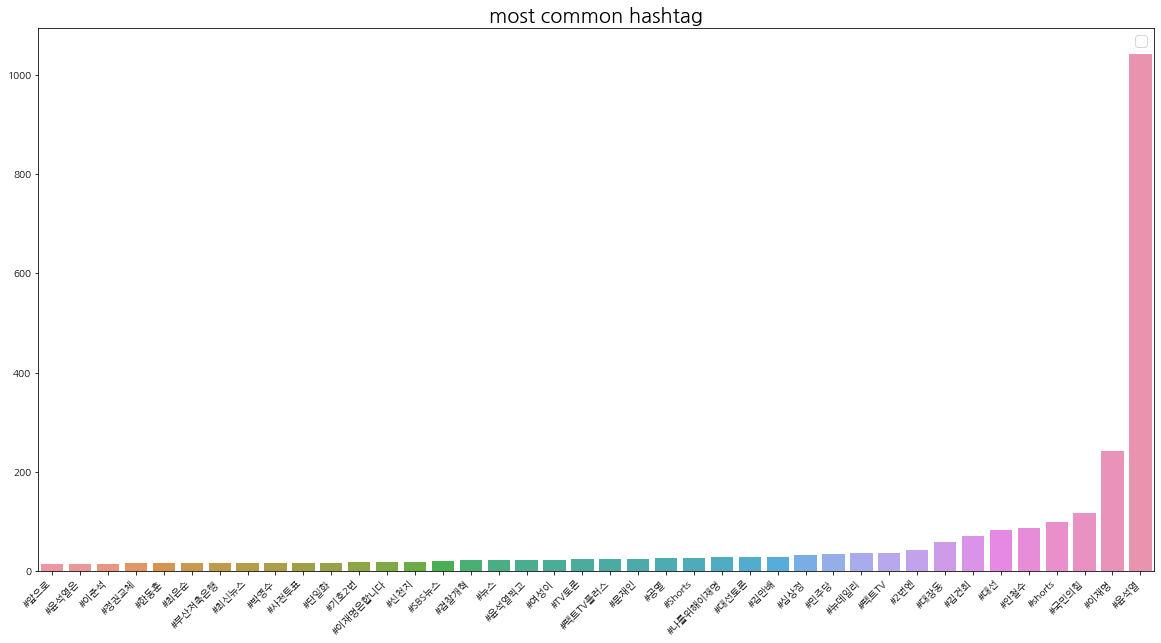

In [38]:
count = dict(Counter(hash).most_common(40))           
hashtag(count)